# 🧠 Intelligent Waste Detection and Classification System using YOLOv11

---

## 🎯 Project Overview

Welcome to the **Intelligent Waste Detection System** project! This notebook serves as a comprehensive guide to building a deep learning model capable of identifying and classifying waste materials in real-time.

### 🌟 Project Goal
To develop a robust AI system that automates waste sorting, contributing to smarter recycling processes and environmental sustainability.

### 🏗️ What You Will Build
By the end of this notebook, you will have:
1.  **Trained** a YOLOv11 object detection model on a custom dataset.
2.  **Evaluated** its performance using industry-standard metrics.
3.  **Exported** the model for deployment.
4.  **Created** a fully functional Streamlit GUI application.

### 🛠️ Technology Stack
*   **Core Model:** [YOLOv11](https://github.com/ultralytics/ultralytics) (You Only Look Once) - State-of-the-art real-time object detection.
*   **Dataset:** Custom Trash Detection Dataset (Roboflow).
*   **Libraries:** `ultralytics`, `opencv`, `pandas`, `matplotlib`.
*   **Deployment:** `Streamlit` for the web interface.

### 📋 Project Workflow
1.  **Environment Setup**: Prepare dependencies and GPU.
2.  **Data Preparation**: Download and explore the dataset.
3.  **Model Training**: Fine-tune YOLOv11 using Transfer Learning.
4.  **Evaluation**: Analyze performance metrics (mAP, Precision, Recall).
5.  **Inference**: Test the model on unseen images.
6.  **Deployment**: Build a user-friendly GUI.

---

## 📋 Step 0: Environment Setup

**What happens here?**
This section prepares your computing environment - whether you're on Google Colab's cloud servers or your local machine. It installs the necessary Python packages and verifies GPU availability for faster training.

In [1]:
# Step 0.1: Detect Runtime Environment
# This checks whether you're running on Google Colab or locally

try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
    print("   → You have access to free GPU resources!")
except:
    IN_COLAB = False
    print("✅ Running on Local Machine")
    print("   → Using your computer's resources")

# If on Colab, display GPU information
if IN_COLAB:
    print("\n" + "="*60)
    print("GPU Information:")
    print("="*60)
    !nvidia-smi
    print("\n💡 Tip: Make sure you've selected a GPU runtime for faster training!")

✅ Running on Google Colab
   → You have access to free GPU resources!

GPU Information:
Fri Nov 21 21:30:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             32W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |         

In [2]:
# Step 0.2: Install Required Packages
# We need two main libraries:
# - roboflow: For downloading the dataset
# - ultralytics: For YOLOv11 model training and inference

print("📦 Installing required packages...")
print("   → roboflow: Dataset management")
print("   → ultralytics: YOLOv11 deep learning framework")
print("\nThis may take 1-2 minutes on first run...\n")

!pip install -q roboflow ultralytics

print("\n✅ All packages installed successfully!")
print("   You're ready to proceed to the next step.")

📦 Installing required packages...
   → roboflow: Dataset management
   → ultralytics: YOLOv11 deep learning framework

This may take 1-2 minutes on first run...


✅ All packages installed successfully!
   You're ready to proceed to the next step.


In [3]:
# Step 0.3: Download the Dataset
# The dataset contains labeled images of trash items in YOLO format

if IN_COLAB:
    from roboflow import Roboflow

    print("="*60)
    print("DATASET DOWNLOAD FROM ROBOFLOW")
    print("="*60)
    print("\n🔑 Authenticating with Roboflow...")
    rf = Roboflow(api_key="WF69uF7yPs7dElPtKYun")

    print("📥 Downloading 'Trash Detection' dataset (v14)...")
    print("   This dataset contains:")
    print("   - 5 waste categories")
    print("   - 2,491 total images (train/validation/test splits)")
    print("   - Bounding box annotations in YOLO format")
    print("\n⏳ Please wait, this may take 2-3 minutes...\n")

    project = rf.workspace("trash-dataset-for-oriented-bounded-box").project("trash-detection-1fjjc")
    version = project.version(14)
    dataset = version.download("yolov11")

    print("\n" + "="*60)
    print("✅ Dataset downloaded successfully!")
    print("="*60)
    print(f"📂 Location: {dataset.location}")

    # Set the dataset path for the rest of the notebook
    DATASET_ROOT = dataset.location

else:
    # Running locally - use pre-downloaded dataset
    DATASET_ROOT = "Trash-Detection-14"
    print("="*60)
    print("USING LOCAL DATASET")
    print("="*60)
    print(f"\n✅ Dataset folder: {DATASET_ROOT}")
    print("   → Make sure this folder exists in your project directory")
    print("   → It should contain: train/, valid/, test/ folders and data.yaml")

DATASET DOWNLOAD FROM ROBOFLOW

🔑 Authenticating with Roboflow...
📥 Downloading 'Trash Detection' dataset (v14)...
   This dataset contains:
   - 5 waste categories
   - 2,491 total images (train/validation/test splits)
   - Bounding box annotations in YOLO format

⏳ Please wait, this may take 2-3 minutes...

loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded successfully!
📂 Location: /content/Trash-Detection-14


## 📚 Step 1: Import Core Libraries

**What happens here?**
We import all the Python libraries needed for:
- **Data handling**: Reading images, labels, and configurations
- **Visualization**: Creating charts and displaying images
- **Deep Learning**: Training the YOLOv11 model
- **Analysis**: Computing statistics and metrics

In [4]:
# Import all necessary libraries

# System and file operations
import os
import yaml
import shutil
from pathlib import Path
from collections import Counter

# Image processing
import cv2
from PIL import Image

# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# YOLOv11 and deep learning
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# Configuration
np.random.seed(42)  # For reproducible results
plt.style.use('default')  # Clean matplotlib style
%matplotlib inline

print("✅ All libraries imported successfully!")
print("\n📦 Key libraries loaded:")
print("   → OpenCV & PIL: Image processing")
print("   → Pandas & NumPy: Data manipulation")
print("   → Matplotlib & Seaborn: Visualization")
print("   → Ultralytics YOLO: Deep learning model")

✅ All libraries imported successfully!

📦 Key libraries loaded:
   → OpenCV & PIL: Image processing
   → Pandas & NumPy: Data manipulation
   → Matplotlib & Seaborn: Visualization
   → Ultralytics YOLO: Deep learning model


## 📊 Step 2: Dataset Analysis and Exploration

**Why is this important?**
Before training any AI model, you must understand your data. This section will show you:
- How many images are in the dataset
- What waste categories exist
- Whether the dataset is balanced (equal examples per class)
- What the labeled images actually look like

This analysis helps you:
- ✅ Verify the dataset is correctly loaded
- ✅ Understand potential biases (some classes having more examples)
- ✅ Set realistic performance expectations

In [5]:
# Step 2.1: Load Dataset Configuration
# The data.yaml file contains all the information about the dataset

DATASET_PATH = Path(DATASET_ROOT)
DATA_YAML = DATASET_PATH / 'data.yaml'

print("="*60)
print("LOADING DATASET CONFIGURATION")
print("="*60)
print(f"\n📂 Dataset Path: {DATASET_PATH}")
print(f"✓ Dataset exists: {DATASET_PATH.exists()}")

# Load the configuration file
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)

print("\n" + "="*60)
print("📖 DATASET CONFIGURATION")
print("="*60)
print(f"\n🎯 Number of Classes: {data_config['nc']}")
print(f"\n📦 Class Names (Waste Categories):")
print("-" * 60)
for idx, name in enumerate(data_config['names']):
    print(f"   {idx}. {name}")
print("-" * 60)

print(f"\n💡 This model will learn to distinguish between {data_config['nc']} types of waste!")

LOADING DATASET CONFIGURATION

📂 Dataset Path: /content/Trash-Detection-14
✓ Dataset exists: True

📖 DATASET CONFIGURATION

🎯 Number of Classes: 5

📦 Class Names (Waste Categories):
------------------------------------------------------------
   0. Glass
   1. Metal
   2. Paper
   3. Plastic
   4. Waste
------------------------------------------------------------

💡 This model will learn to distinguish between 5 types of waste!



ANALYZING DATASET SPLITS

📊 Image Distribution:
------------------------------------------------------------
   🏋️  Training Set:   6,000 images (88.5%)
   ✅ Validation Set: 673 images (9.9%)
   🧪 Test Set:       110 images (1.6%)
------------------------------------------------------------
   📦 Total:          6,783 images
------------------------------------------------------------

💡 What each split does:
   → Training: Used to teach the model
   → Validation: Used to tune the model during training
   → Test: Used to evaluate final model performance on unseen data




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



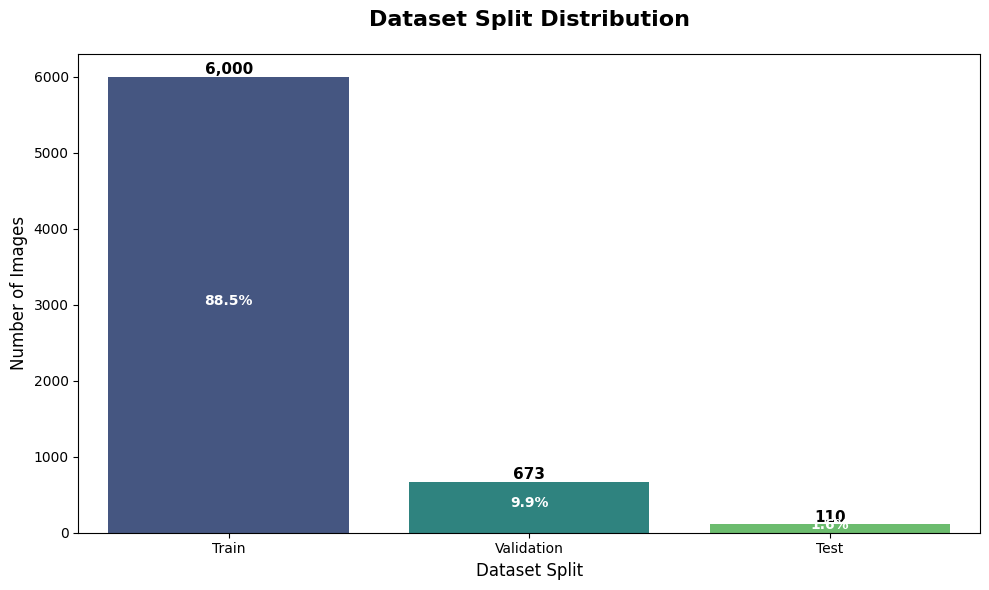


✅ Dataset split looks good! Ready for training.


In [6]:
# Step 2.2: Analyze Dataset Split
# Count images in each subset (train/validation/test)

print("\n" + "="*60)
print("ANALYZING DATASET SPLITS")
print("="*60)

train_images = list((DATASET_PATH / 'train' / 'images').glob('*.jpg'))
valid_images = list((DATASET_PATH / 'valid' / 'images').glob('*.jpg'))
test_images = list((DATASET_PATH / 'test' / 'images').glob('*.jpg'))

total_images = len(train_images) + len(valid_images) + len(test_images)

print(f"\n📊 Image Distribution:")
print("-" * 60)
print(f"   🏋️  Training Set:   {len(train_images):,} images ({len(train_images)/total_images*100:.1f}%)")
print(f"   ✅ Validation Set: {len(valid_images):,} images ({len(valid_images)/total_images*100:.1f}%)")
print(f"   🧪 Test Set:       {len(test_images):,} images ({len(test_images)/total_images*100:.1f}%)")
print("-" * 60)
print(f"   📦 Total:          {total_images:,} images")
print("-" * 60)

print("\n💡 What each split does:")
print("   → Training: Used to teach the model")
print("   → Validation: Used to tune the model during training")
print("   → Test: Used to evaluate final model performance on unseen data")

# Visualize the split distribution
split_data = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Count': [len(train_images), len(valid_images), len(test_images)]
})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=split_data, x='Split', y='Count', palette='viridis')
plt.title('Dataset Split Distribution', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Dataset Split', fontsize=12)

# Add count labels on bars
for i, v in enumerate(split_data['Count']):
    ax.text(i, v + 30, f'{v:,}', ha='center', fontweight='bold', fontsize=11)
    ax.text(i, v/2, f'{v/total_images*100:.1f}%', ha='center', color='white', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Dataset split looks good! Ready for training.")


ANALYZING CLASS DISTRIBUTION

⏳ Counting instances of each waste type in training set...

📊 Class Distribution in Training Set:
------------------------------------------------------------
  Class  Instances  Percentage
Plastic       6007        46.1
  Waste       3487        26.7
  Metal       1536        11.8
  Paper       1212         9.3
  Glass        800         6.1
------------------------------------------------------------
Total Instances: 13,042
------------------------------------------------------------

📈 Class Balance Analysis:
   → Most common class:  Plastic (6,007 instances)
   → Least common class: Glass (800 instances)
   → Imbalance ratio: 7.51x
   ⚠️  Moderate class imbalance detected
      The model might be better at detecting common classes




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



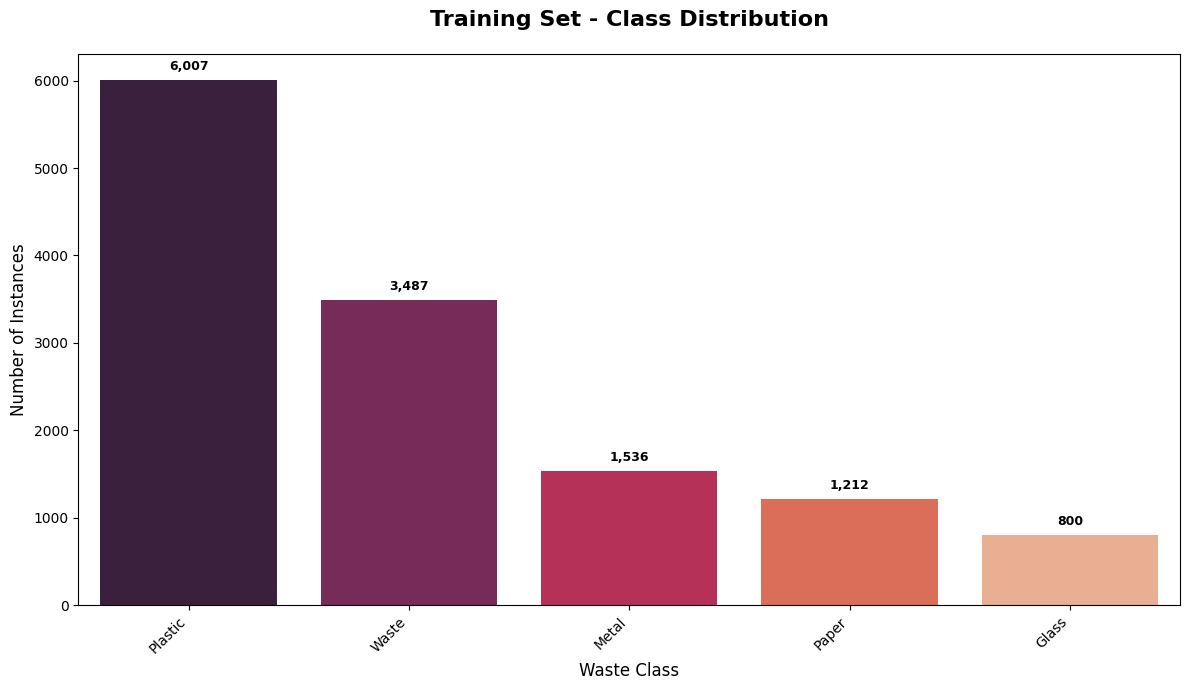

In [7]:
# Step 2.3: Analyze Class Distribution
# Check how many examples of each waste type we have

def count_classes_in_labels(label_dir):
    """Counts how many times each class appears in the label files."""
    class_counts = Counter()
    label_files = list(Path(label_dir).glob('*.txt'))

    for label_file in label_files:
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1

    return class_counts

print("\n" + "="*60)
print("ANALYZING CLASS DISTRIBUTION")
print("="*60)
print("\n⏳ Counting instances of each waste type in training set...\n")

# Count occurrences of each class
train_class_counts = count_classes_in_labels(DATASET_PATH / 'train' / 'labels')

# Create a detailed table
class_dist_df = pd.DataFrame([
    {'Class': data_config['names'][class_id], 'Instances': count}
    for class_id, count in sorted(train_class_counts.items())
]).sort_values('Instances', ascending=False)

# Calculate percentages
total_instances = class_dist_df['Instances'].sum()
class_dist_df['Percentage'] = (class_dist_df['Instances'] / total_instances * 100).round(1)

print("📊 Class Distribution in Training Set:")
print("-" * 60)
print(class_dist_df.to_string(index=False))
print("-" * 60)
print(f"Total Instances: {total_instances:,}")
print("-" * 60)

# Check for class imbalance
max_count = class_dist_df['Instances'].max()
min_count = class_dist_df['Instances'].min()
imbalance_ratio = max_count / min_count

print(f"\n📈 Class Balance Analysis:")
print(f"   → Most common class:  {class_dist_df.iloc[0]['Class']} ({class_dist_df.iloc[0]['Instances']:,} instances)")
print(f"   → Least common class: {class_dist_df.iloc[-1]['Class']} ({class_dist_df.iloc[-1]['Instances']:,} instances)")
print(f"   → Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 3:
    print(f"   ⚠️  Moderate class imbalance detected")
    print(f"      The model might be better at detecting common classes")
else:
    print(f"   ✅ Dataset is reasonably balanced")

# Visualize class distribution
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=class_dist_df, x='Class', y='Instances', palette='rocket')
plt.title('Training Set - Class Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Waste Class', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold')

plt.tight_layout()
plt.show()


VISUALIZING SAMPLE TRAINING DATA

🖼️  Displaying 6 random training images with annotations...
   Green boxes show labeled trash items with their class names



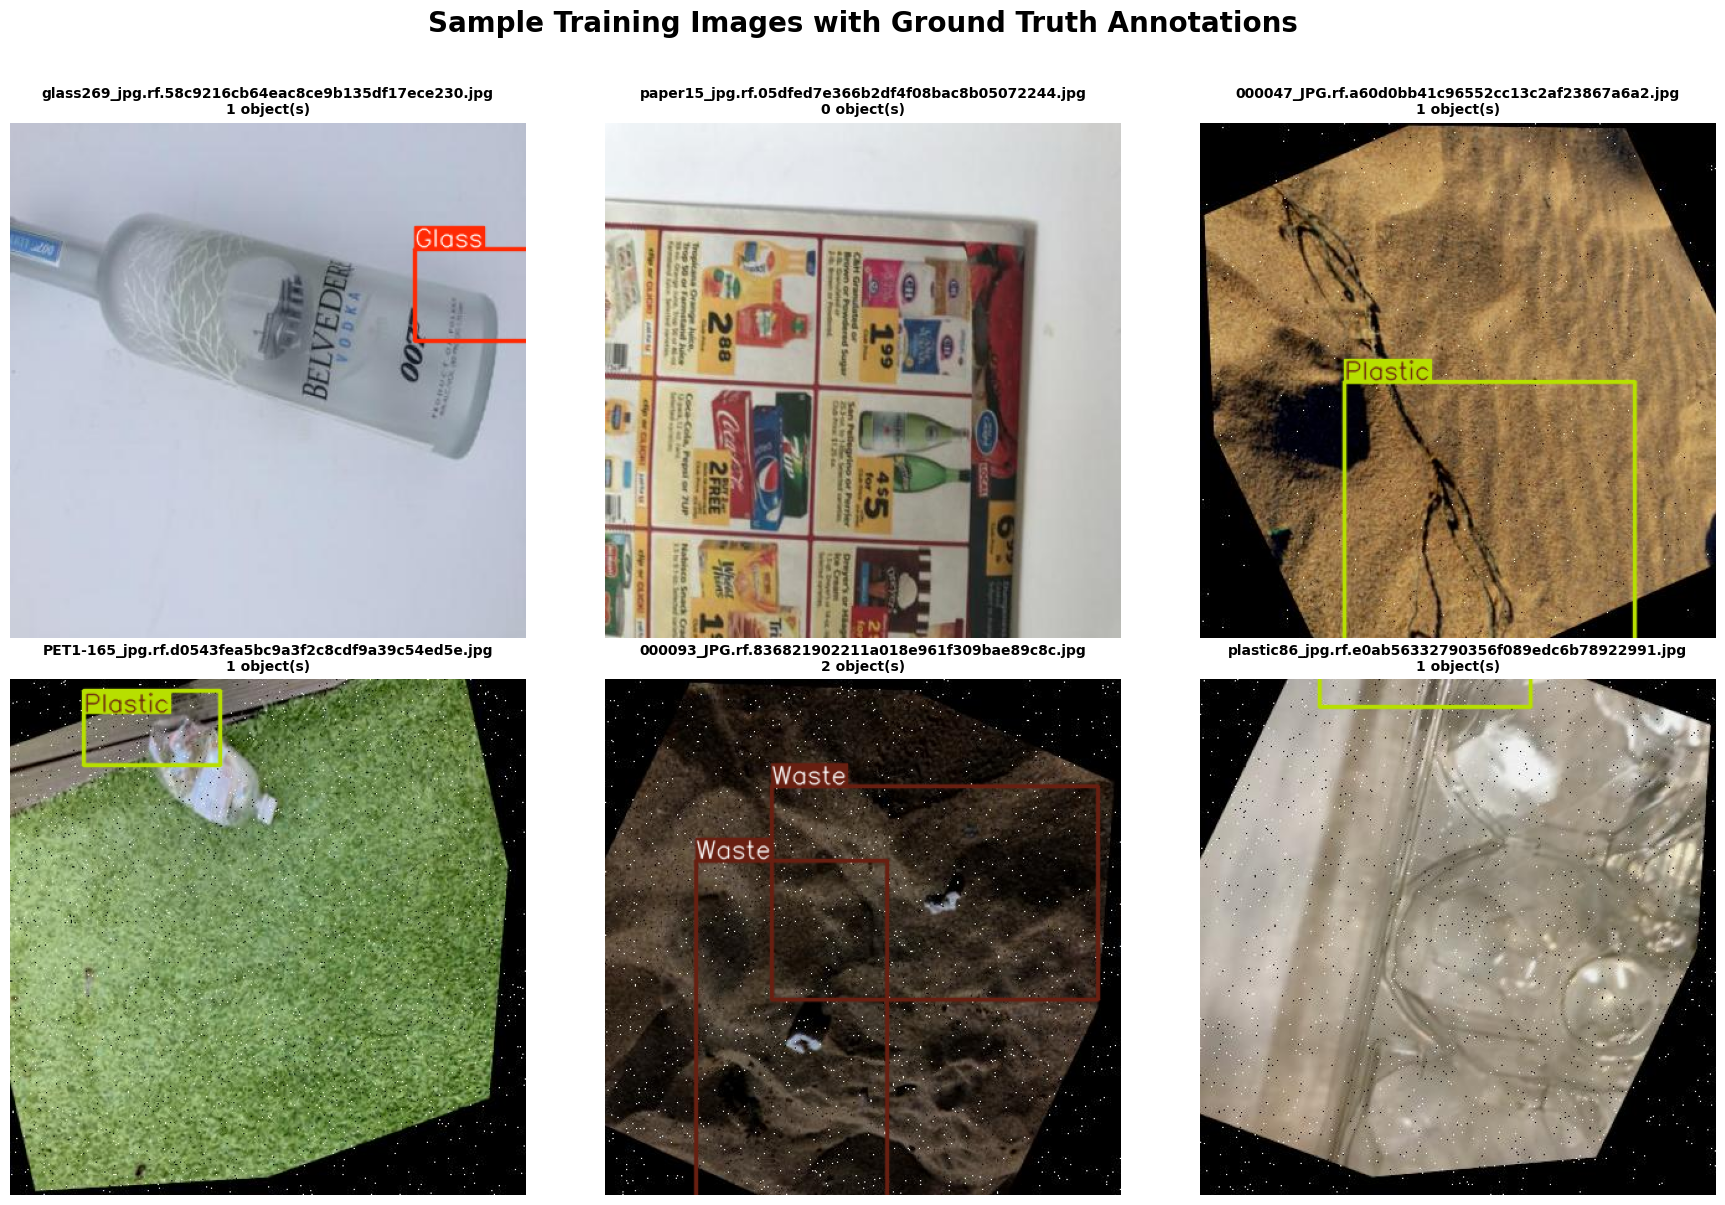

✅ Sample images displayed successfully!
💡 Notice how each trash item is labeled with its category


In [8]:
# Step 2.4: Visualize Sample Images with Annotations
# Let's see what the actual labeled training data looks like!

def visualize_sample_images(image_dir, label_dir, class_names, num_samples=6):
    """
    Displays a grid of sample images with their labeled bounding boxes.
    This helps verify that:
    - Images are loading correctly
    - Labels are properly formatted
    - Bounding boxes are accurate
    """
    image_files = list(Path(image_dir).glob('*.jpg'))
    num_samples = min(num_samples, len(image_files))
    samples = np.random.choice(image_files, num_samples, replace=False)

    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten()

    print(f"\n🖼️  Displaying {num_samples} random training images with annotations...")
    print("   Green boxes show labeled trash items with their class names\n")

    for idx, img_path in enumerate(samples):
        # Load image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Load corresponding labels
        label_path = Path(label_dir) / f"{img_path.stem}.txt"
        annotator = Annotator(img, line_width=2, example=str(class_names))

        num_objects = 0
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])

                        # Convert YOLO format (normalized) to pixel coordinates
                        x1 = (x_center - width / 2) * w
                        y1 = (y_center - height / 2) * h
                        x2 = (x_center + width / 2) * w
                        y2 = (y_center + height / 2) * h

                        # Draw bounding box
                        annotator.box_label([x1, y1, x2, y2], class_names[class_id], color=colors(class_id, True))
                        num_objects += 1

        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.name}\n{num_objects} object(s)", fontweight='bold', fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Sample Training Images with Ground Truth Annotations',
                 fontsize=20, fontweight='bold', y=1.00)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("✅ Sample images displayed successfully!")
    print("💡 Notice how each trash item is labeled with its category")

# Display sample images
print("\n" + "="*60)
print("VISUALIZING SAMPLE TRAINING DATA")
print("="*60)

visualize_sample_images(
    DATASET_PATH / 'train' / 'images',
    DATASET_PATH / 'train' / 'labels',
    data_config['names'],
    num_samples=6
)

## ⚙️ Step 3: Model Configuration and Training

### 🧠 The Power of Transfer Learning
We will use **Transfer Learning** to train our model. Instead of starting from scratch (random weights), we initialize our YOLOv11 model with weights pre-trained on the massive **COCO dataset**.
*   **Benefit:** The model already understands basic features like edges, shapes, and textures.
*   **Task:** We simply "fine-tune" it to recognize our specific classes: *Glass, Metal, Paper, Plastic, and Waste*.

### 🔧 Key Hyperparameters
*   **Epochs:** One full pass through the entire dataset.
*   **Batch Size:** Number of images processed at once before updating weights.
*   **Image Size:** Resolution of input images (e.g., 640x640).
*   **Learning Rate:** Step size for the optimizer.

**Note:** Training on a GPU (like T4 in Colab) is highly recommended as it accelerates the process significantly (minutes vs. hours).

In [9]:
# Step 3.1: Initialize the YOLOv11 Model
# We'll use the 'large' version for maximum accuracy

print("="*60)
print("INITIALIZING YOLO v11 MODEL")
print("="*60)

print("\n📦 Available YOLOv11 model sizes:")
print("   • yolo11n (nano)   - Fastest, smaller file size, good accuracy")
print("   • yolo11s (small)  - Balanced")
print("   • yolo11m (medium) - More accurate, slower ⭐ Our choice")
print("   • yolo11l (large)  - Very accurate, much slower")
print("   • yolo11x (xlarge) - Maximum accuracy, very slow")

model_size = 'yolo11m'
print(f"\n🎯 Loading {model_size} with pre-trained weights...")

model = YOLO(f'{model_size}.pt')

print(f"\n✅ Model loaded successfully!")
print(f"\n💡 Why pre-trained weights?")
print(f"   This model was already trained on COCO dataset (80 object categories)")
print(f"   It already knows how to detect objects - we're just fine-tuning it")
print(f"   for trash detection. This is called 'Transfer Learning'!")
print(f"\n📊 Model will learn to detect {data_config['nc']} waste categories")


INITIALIZING YOLO v11 MODEL

📦 Available YOLOv11 model sizes:
   • yolo11n (nano)   - Fastest, smaller file size, good accuracy
   • yolo11s (small)  - Balanced
   • yolo11m (medium) - More accurate, slower ⭐ Our choice
   • yolo11l (large)  - Very accurate, much slower
   • yolo11x (xlarge) - Maximum accuracy, very slow

🎯 Loading yolo11m with pre-trained weights...

✅ Model loaded successfully!

💡 Why pre-trained weights?
   This model was already trained on COCO dataset (80 object categories)
   It already knows how to detect objects - we're just fine-tuning it
   for trash detection. This is called 'Transfer Learning'!

📊 Model will learn to detect 5 waste categories


In [10]:
# Step 3.2: Configure Training Hyperparameters
# These settings control how the model learns

print("\n" + "="*60)
print("CONFIGURING TRAINING HYPERPARAMETERS")
print("="*60)

EPOCHS = 50           # How many times to go through the entire dataset
IMG_SIZE = 640        # Input image size (640x640 pixels)
BATCH_SIZE = 16       # Number of images processed together
LEARNING_RATE = 0.01  # How fast the model learns (0.01 = 1%)
PATIENCE = 10         # Stop early if no improvement for 10 epochs

print("\n⚙️  Training Configuration:")
print("-" * 60)
print(f"   Epochs:               {EPOCHS}")
print(f"   Image Size:           {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"   Batch Size:           {BATCH_SIZE} images per batch")
print(f"   Learning Rate:        {LEARNING_RATE}")
print(f"   Early Stop Patience:  {PATIENCE} epochs")
print("-" * 60)

print(f"\n🖥️  Computing Environment: {'Google Colab (GPU)' if IN_COLAB else 'Local Machine (CPU)'}")

if IN_COLAB:
    print(f"   ⚡ GPU Training enabled - This will be fast!")
    print(f"   ⏱️  Estimated time: 30-45 minutes")
else:
    print(f"   ⚠️  CPU Training - This will be slower")
    print(f"   ⏱️  Estimated time: 2-4 hours")

print("\n💡 What these parameters mean:")
print("   • Epochs: More = better learning, but diminishing returns after 50-100")
print("   • Image Size: Larger = more detail but slower training")
print("   • Batch Size: Larger = faster but needs more memory")
print("   • Learning Rate: Too high = unstable, too low = slow learning")
print("   • Patience: Prevents overfitting by stopping when validation stops improving")


CONFIGURING TRAINING HYPERPARAMETERS

⚙️  Training Configuration:
------------------------------------------------------------
   Epochs:               50
   Image Size:           640x640 pixels
   Batch Size:           16 images per batch
   Learning Rate:        0.01
   Early Stop Patience:  10 epochs
------------------------------------------------------------

🖥️  Computing Environment: Google Colab (GPU)
   ⚡ GPU Training enabled - This will be fast!
   ⏱️  Estimated time: 30-45 minutes

💡 What these parameters mean:
   • Epochs: More = better learning, but diminishing returns after 50-100
   • Image Size: Larger = more detail but slower training
   • Batch Size: Larger = faster but needs more memory
   • Learning Rate: Too high = unstable, too low = slow learning
   • Patience: Prevents overfitting by stopping when validation stops improving


In [11]:
# Step 3.3: Start Model Training!
# This will take some time - grab a coffee! ☕

print("\n" + "="*60)
print("🚀 STARTING MODEL TRAINING")
print("="*60)
print("\n⏳ Training in progress... This cell may take 30-45 minutes on GPU")
print("\n📊 Watch for these metrics during training:")
print("   • Loss (box, cls, dfl): Lower is better - measures prediction errors")
print("   • Precision: % of detections that are correct")
print("   • Recall: % of actual objects that were detected")
print("   • mAP: Overall performance score (higher is better)")
print("\n💡 The model will automatically:")
print("   ✓ Save checkpoints during training")
print("   ✓ Validate on validation set after each epoch")
print("   ✓ Stop early if performance plateaus")
print("   ✓ Save the best performing model")
print("\n" + "="*60 + "\n")

# Start training!
results = model.train(
    data=str(DATA_YAML),          # Dataset configuration
    epochs=EPOCHS,                # Number of training epochs
    imgsz=IMG_SIZE,               # Image dimensions
    batch=BATCH_SIZE,             # Batch size
    lr0=LEARNING_RATE,            # Initial learning rate
    patience=PATIENCE,            # Early stopping patience
    save=True,                    # Save checkpoints
    device=0 if IN_COLAB else 'cpu',  # Use GPU if available
    project='runs/detect',        # Output directory
    name='trash_detection_yolo11',# Experiment name
    exist_ok=True,                # Overwrite if exists
    pretrained=True,              # Use pre-trained weights
    optimizer='auto',             # Auto-select optimizer
    verbose=True,                 # Show detailed progress
    seed=42,                      # Random seed for reproducibility
    deterministic=True,           # Ensure reproducible results
    val=True,                     # Run validation
    plots=True                    # Generate performance plots
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print("\n📁 Results saved to: runs/detect/trash_detection_yolo11/")
print("   → weights/best.pt    (best model)")
print("   → weights/last.pt    (final epoch model)")
print("   → results.png        (training curves)")
print("   → confusion_matrix.png (performance by class)")
print("\n🎉 Your trash detection model is ready!")


🚀 STARTING MODEL TRAINING

⏳ Training in progress... This cell may take 30-45 minutes on GPU

📊 Watch for these metrics during training:
   • Loss (box, cls, dfl): Lower is better - measures prediction errors
   • Precision: % of detections that are correct
   • Recall: % of actual objects that were detected
   • mAP: Overall performance score (higher is better)

💡 The model will automatically:
   ✓ Save checkpoints during training
   ✓ Validate on validation set after each epoch
   ✓ Stop early if performance plateaus
   ✓ Save the best performing model


Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Trash-Detection-14/data.yaml, degrees=0.0, deterministic=True, device=0

## 4. 📈 Training Results and Visualization

Now that training is complete, we need to interpret the results. We will look at several key visualizations:

### 📊 Key Metrics Explained
*   **Loss Curves:** Show how well the model is learning. We want these to decrease over time.
    *   *Box Loss:* Error in predicted bounding box coordinates.
    *   *Cls Loss:* Error in classifying the object.
*   **mAP (Mean Average Precision):** The gold standard for object detection accuracy.
    *   **mAP@50:** Accuracy when the overlap between prediction and ground truth is at least 50%.
    *   **mAP@50-95:** A stricter metric averaging accuracy across multiple overlap thresholds (50% to 95%).

### 🧩 Confusion Matrix
This matrix helps us see where the model gets confused. For example, does it often mistake *Glass* for *Plastic*?

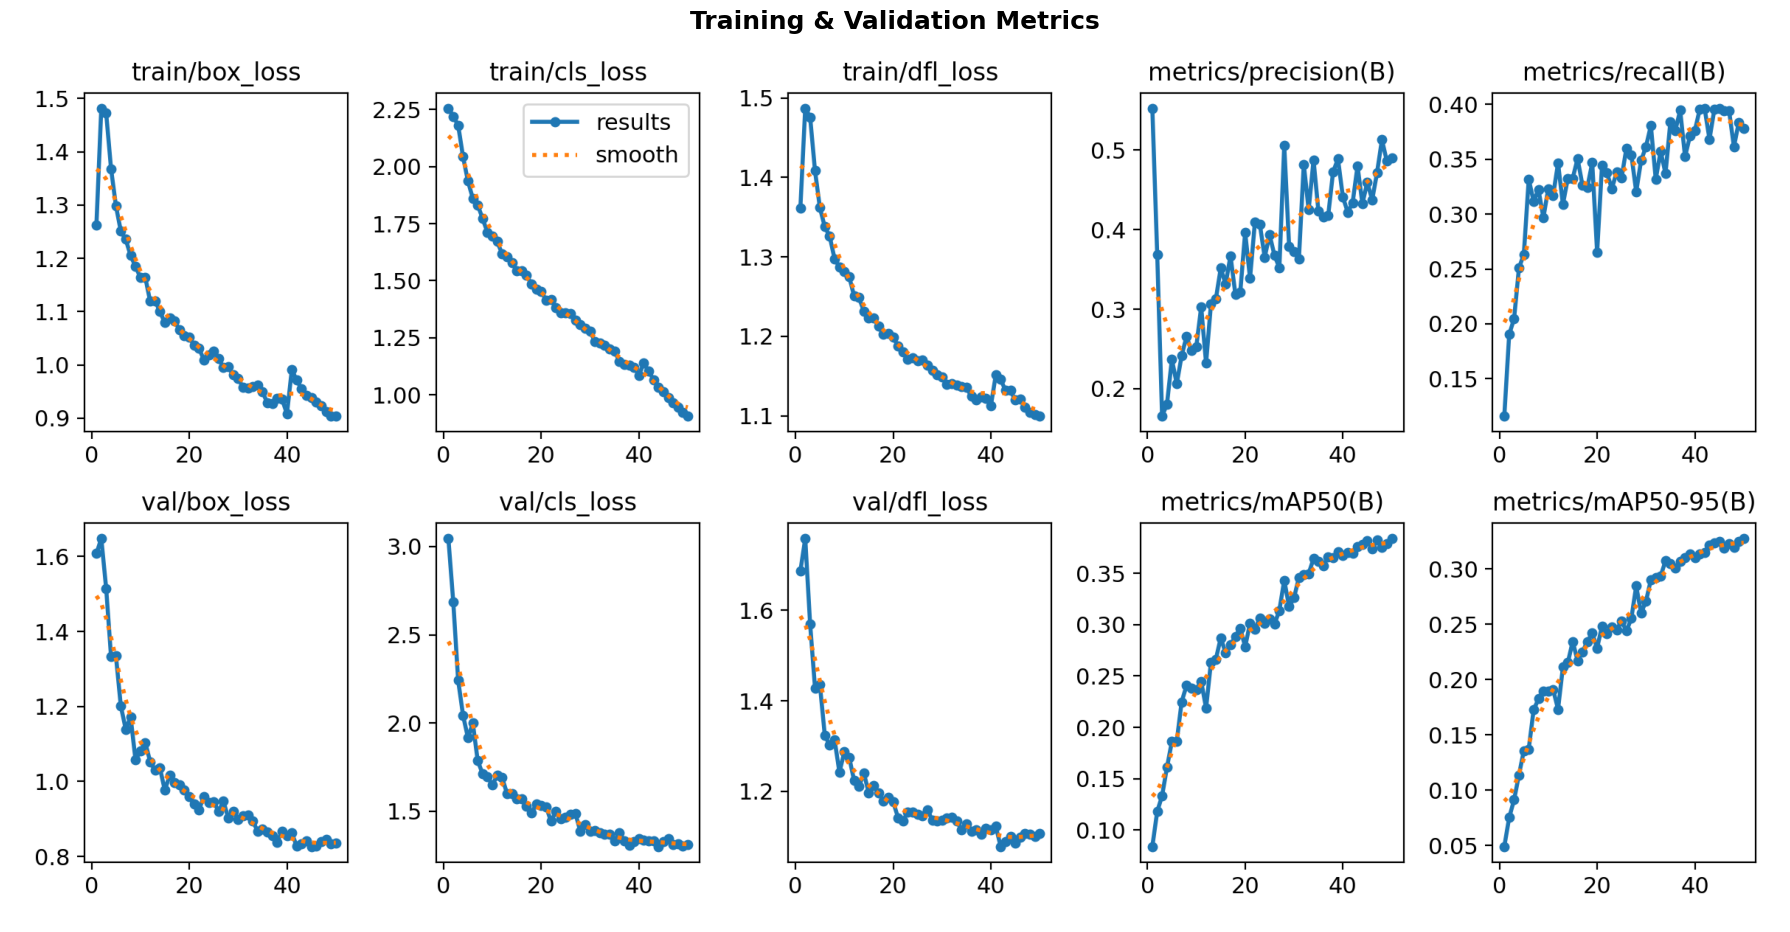

In [12]:
# Define the directory where training results are saved
results_dir = Path('runs/detect/trash_detection_yolo11')

# Display the training curves (loss, mAP, etc.)
results_img_path = results_dir / 'results.png'
if results_img_path.exists():
    img = Image.open(results_img_path)
    plt.figure(figsize=(18, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training & Validation Metrics', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ Results image not found at: {results_img_path}")

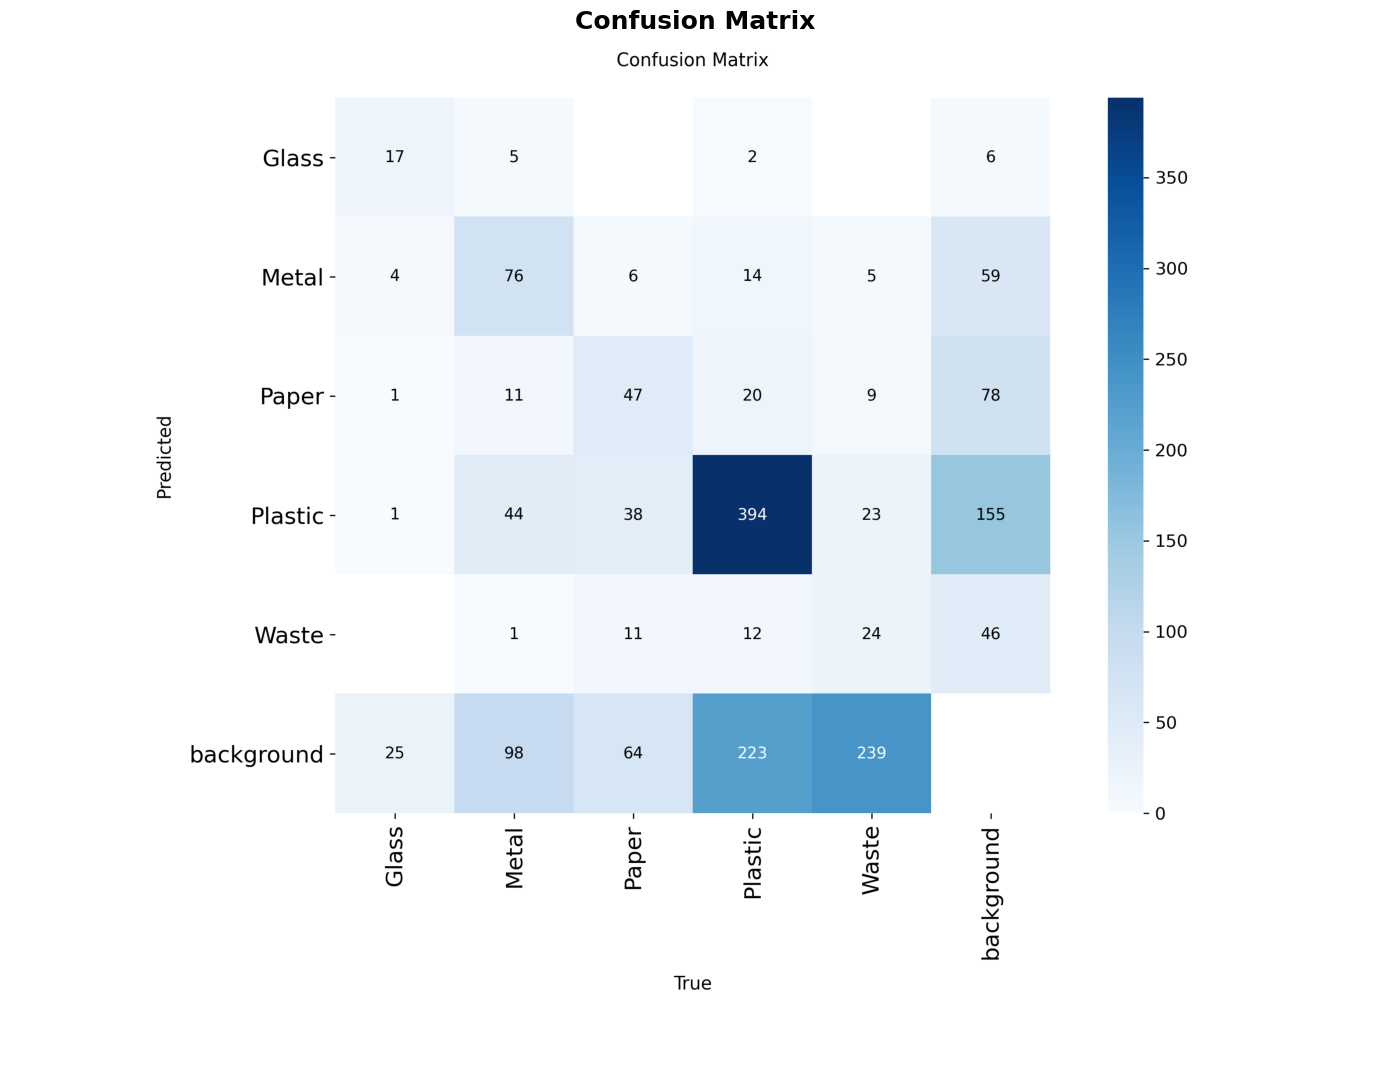

In [13]:
# Display the confusion matrix to see class-wise performance
confusion_matrix_path = results_dir / 'confusion_matrix.png'
if confusion_matrix_path.exists():
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(14, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(f"❌ Confusion matrix not found at: {confusion_matrix_path}")

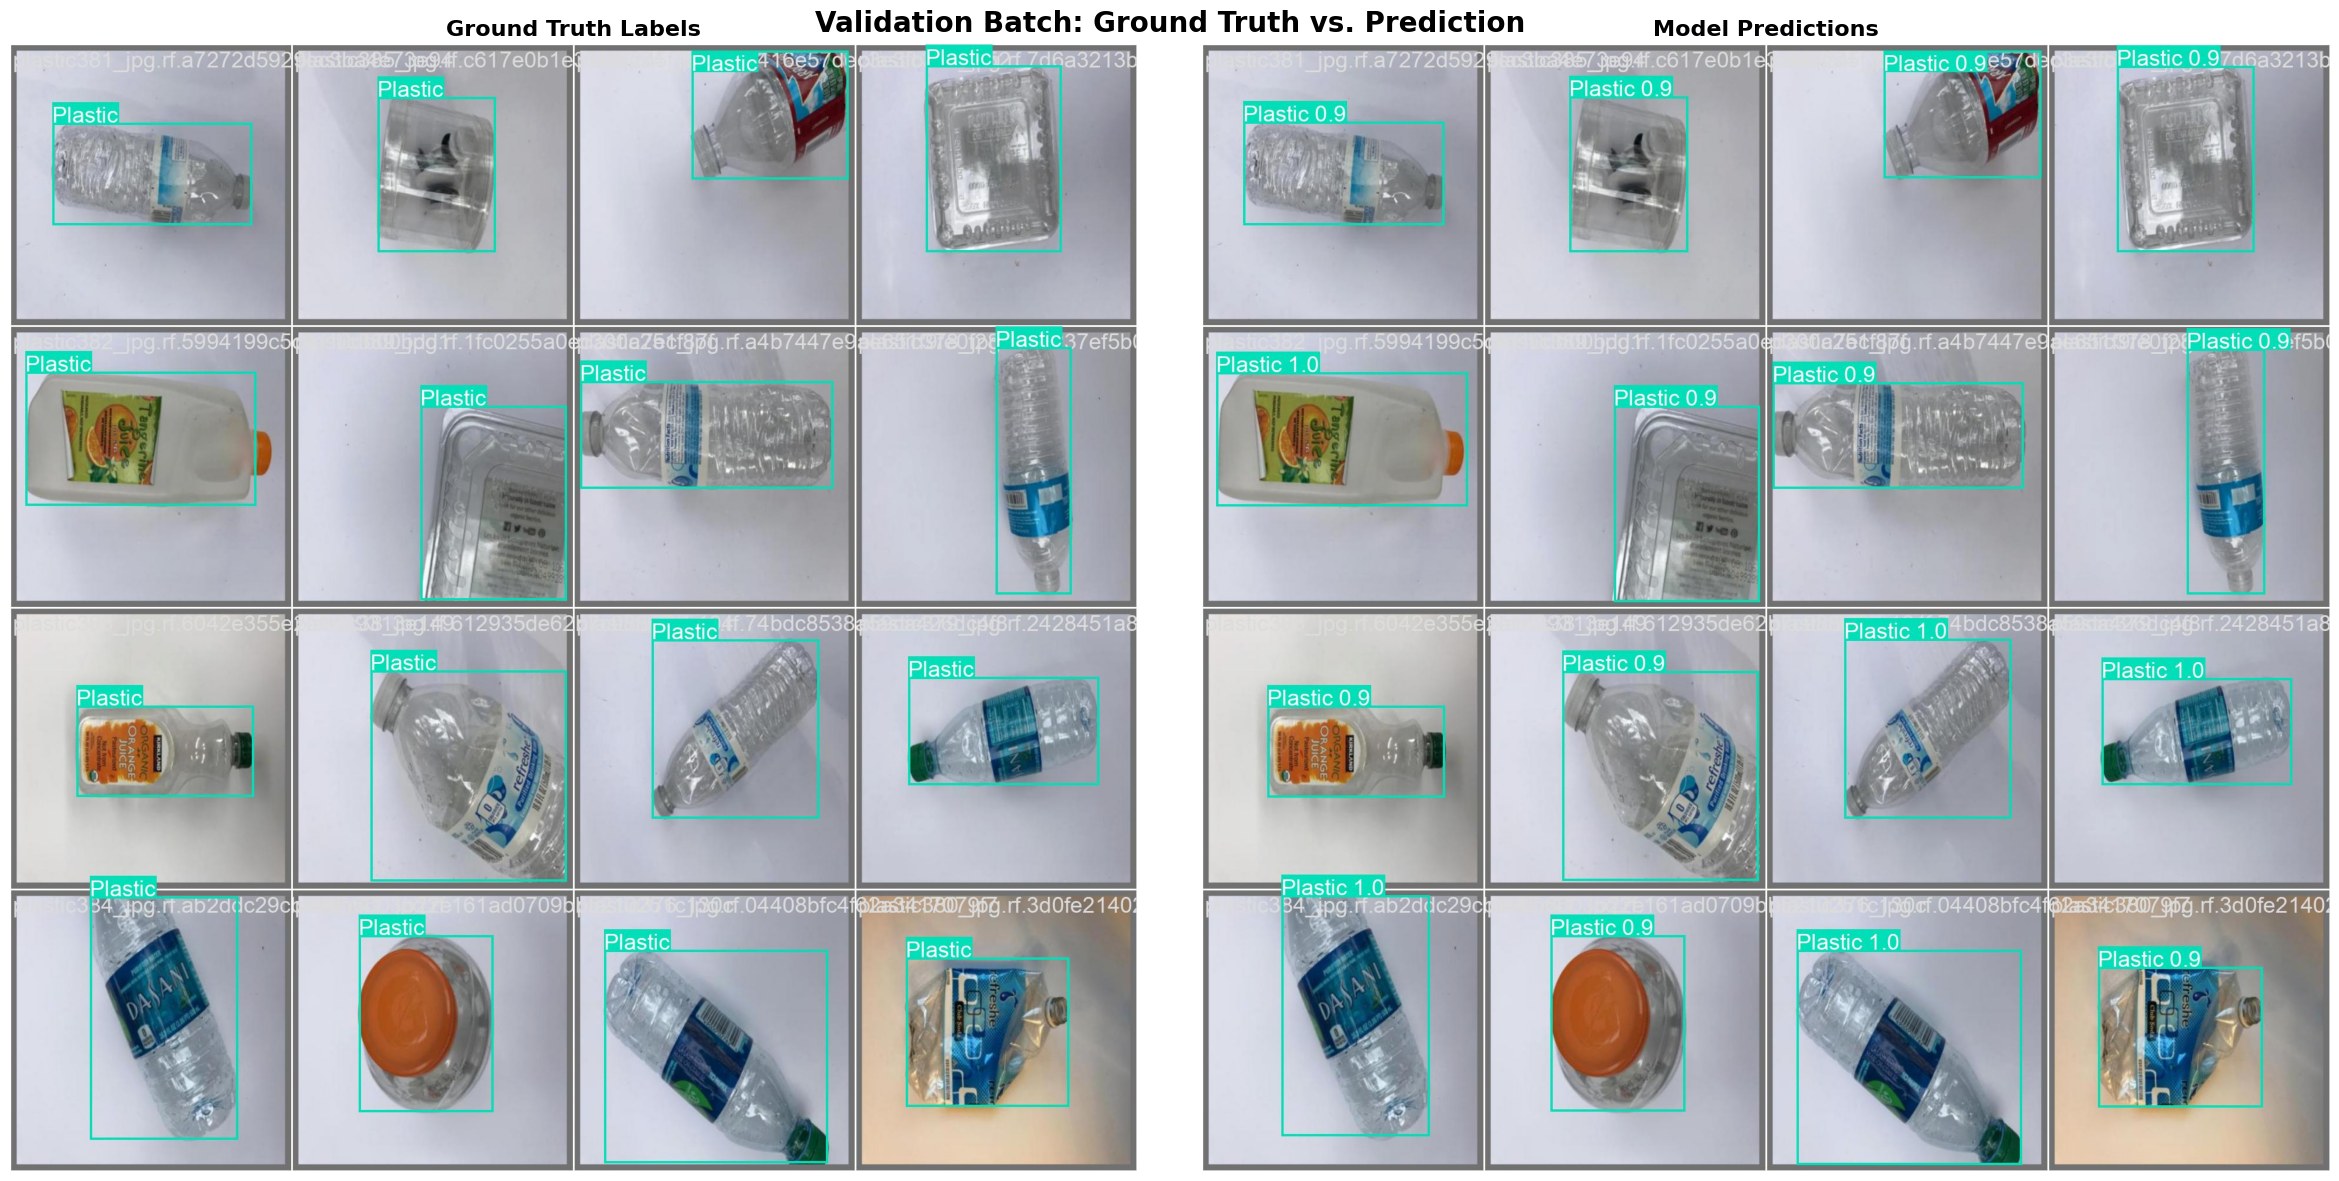

In [14]:
# Display sample predictions from a validation batch
val_batch_labels_path = results_dir / 'val_batch0_labels.jpg'
val_batch_pred_path = results_dir / 'val_batch0_pred.jpg'

if val_batch_labels_path.exists() and val_batch_pred_path.exists():
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))

    # --- Ground Truth ---
    img_labels = Image.open(val_batch_labels_path)
    axes[0].imshow(img_labels)
    axes[0].set_title('Ground Truth Labels', fontsize=16, fontweight='bold')
    axes[0].axis('off')

    # --- Model Predictions ---
    img_pred = Image.open(val_batch_pred_path)
    axes[1].imshow(img_pred)
    axes[1].set_title('Model Predictions', fontsize=16, fontweight='bold')
    axes[1].axis('off')

    plt.suptitle('Validation Batch: Ground Truth vs. Prediction', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Validation batch images not found. They are generated during training.")

## 5. 🧪 Model Evaluation on the Test Set

After training, the model's generalization ability must be tested on unseen data. The test set serves this purpose.
- **Load Best Model**: We load the model weights that achieved the best validation performance during training (`best.pt`).
- **Evaluate**: The `model.val()` function is used with `split='test'` to run evaluation on the test set.
- **Analyze Metrics**: We extract and display key object detection metrics:
    - **Precision**: The accuracy of positive predictions.
    - **Recall**: The ability of the model to find all relevant instances.
    - **mAP@0.5**: Mean Average Precision at an IoU threshold of 50%.
    - **mAP@0.5:0.95**: The primary challenge metric, averaged over multiple IoU thresholds.

In [15]:
# Load the best performing model saved during training
best_model_path = results_dir / 'weights' / 'best.pt'

if best_model_path.exists():
    best_model = YOLO(str(best_model_path))
    print("✅ Best model loaded successfully!")
    print(f"Model path: {best_model_path}")
else:
    print("❌ Best model not found. Please ensure training was completed.")
    best_model = None

✅ Best model loaded successfully!
Model path: runs/detect/trash_detection_yolo11/weights/best.pt


In [16]:
# Evaluate the best model on the test set
if best_model:
    print("\n🧪 Evaluating model performance on the test set...\n")

    test_results = best_model.val(
        data=str(DATA_YAML),
        split='test',
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        plots=True,
        save_json=True,  # Save results to a JSON file for detailed analysis
        project='runs/detect',
        name='test_evaluation',
        exist_ok=True
    )

    print("\n✅ Test Set Evaluation Completed!")
else:
    print("Skipping test set evaluation as the best model was not loaded.")
    test_results = None


🧪 Evaluating model performance on the test set...

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 49.8±76.7 MB/s, size: 35.3 KB)
val: Scanning /content/Trash-Detection-14/test/labels... 110 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 110/110 1.1Kit/s 0.1s
val: New cache created: /content/Trash-Detection-14/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.6it/s 4.3s
                   all        110        175      0.699      0.535      0.582      0.543
                 Glass         35         60      0.912      0.521      0.601      0.558
                 Metal         18         25      0.699       0.68      0.718      0.683
                 Paper         15         18      0.521      0.667      0.672       0.63
             


📊 TEST SET PERFORMANCE METRICS
  - Precision      : 0.6985
  - Recall         : 0.5353
  - mAP@0.5        : 0.5820
  - mAP@0.5:0.95   : 0.5429


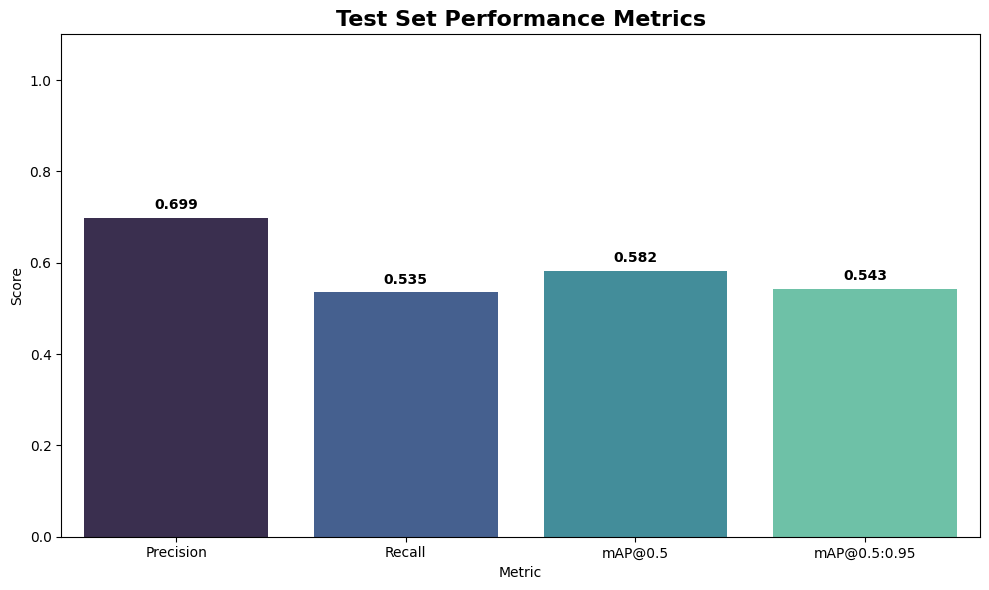

In [17]:
# Display the final performance metrics from the test set
if test_results:
    print("\n" + "="*60)
    print("📊 TEST SET PERFORMANCE METRICS")
    print("="*60)

    # Extract key metrics from the results dictionary
    metrics_dict = {
        'Precision': test_results.results_dict.get('metrics/precision(B)', 0),
        'Recall': test_results.results_dict.get('metrics/recall(B)', 0),
        'mAP@0.5': test_results.results_dict.get('metrics/mAP50(B)', 0),
        'mAP@0.5:0.95': test_results.results_dict.get('metrics/mAP50-95(B)', 0)
    }

    for metric, value in metrics_dict.items():
        print(f"  - {metric:15s}: {value:.4f}")

    print("="*60)

    # Visualize the metrics in a bar chart
    plt.figure(figsize=(10, 6))
    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    ax = sns.barplot(data=metrics_df, x='Metric', y='Value', palette='mako')

    plt.title('Test Set Performance Metrics', fontsize=16, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.ylabel('Score')

    # Add score labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points',
                    fontweight='bold')

    plt.tight_layout()
    plt.show()

## 6. 🔍 Inference on Sample Images

Inference is the process of using the trained model to make predictions on new, unseen images. This section demonstrates how to:
- Run predictions on a batch of random test images.
- Perform a detailed analysis on a single image, showing the annotated image and a table of detected objects with their confidence scores.

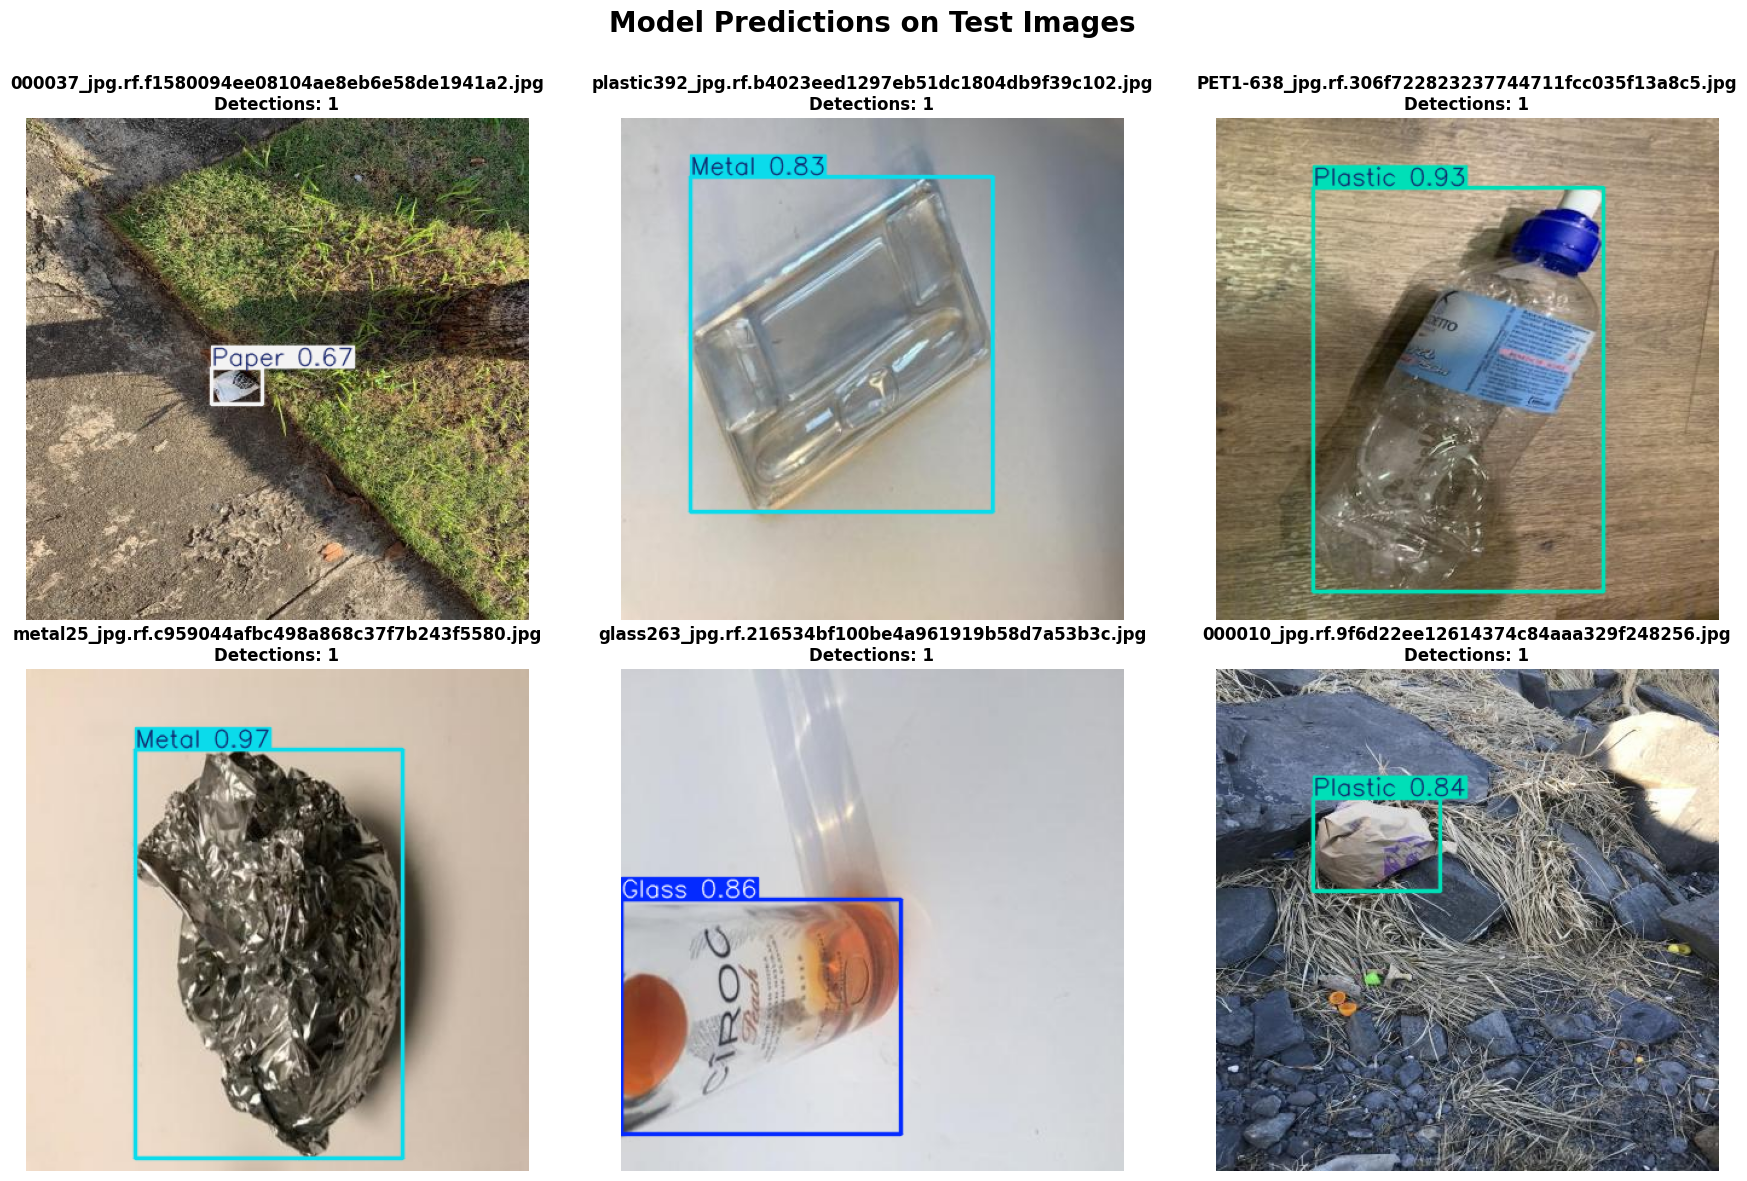

In [18]:
# Function to run inference and visualize results on multiple images
def predict_and_visualize(model, image_paths, conf_threshold=0.25):
    """Runs inference on a list of images and displays the results in a grid."""
    if model is None or len(image_paths) == 0:
        print("Model or image paths not provided.")
        return

    num_images = len(image_paths)
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for idx, img_path in enumerate(image_paths):
        # Run inference on the image
        results = model.predict(
            source=str(img_path),
            conf=conf_threshold,
            save=False,
            verbose=False
        )

        # Get the annotated image from the results
        annotated_img = results[0].plot()
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        # Count the number of detections
        num_detections = len(results[0].boxes)

        # Display the image
        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f"{img_path.name}\nDetections: {num_detections}", fontweight='bold', fontsize=12)
        axes[idx].axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Model Predictions on Test Images', fontsize=20, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Select a few random images from the test set for inference
if len(test_images) > 0:
    sample_test_images = np.random.choice(test_images, min(6, len(test_images)), replace=False)
    # Run inference and visualization
    predict_and_visualize(best_model, sample_test_images, conf_threshold=0.4)
else:
    print("No test images found to run inference on.")

🕵️‍♂️ Analyzing single image: paper222_jpg.rf.56ff76e0871d07f3a72f2f3990c307cb.jpg



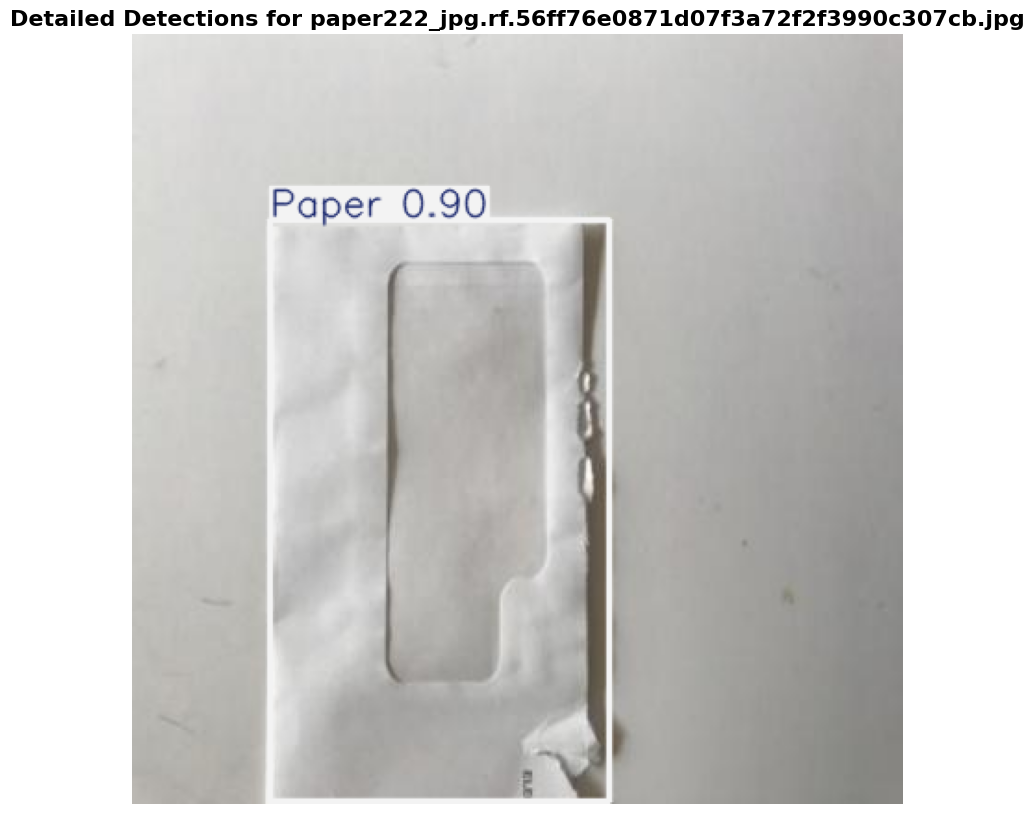


Detected Objects:
-----------------------------------------------------------------
 Detection Class Confidence
         1 Paper     89.65%
-----------------------------------------------------------------
Total Detections: 1


In [19]:
# Function for detailed inference on a single image
def detailed_inference(model, image_path, conf_threshold=0.25):
    """Runs inference on a single image and provides detailed output."""
    if not model:
        print("Model not loaded.")
        return

    # Run prediction
    results = model.predict(
        source=str(image_path),
        conf=conf_threshold,
        save=False,
        verbose=False
    )

    # Get the first result object
    result = results[0]
    boxes = result.boxes

    # --- Display Annotated Image ---
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(14, 10))
    plt.imshow(annotated_img)
    plt.title(f'Detailed Detections for {image_path.name}', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.show()

    # --- Display Detection Details in a Table ---
    if len(boxes) > 0:
        print("\nDetected Objects:")
        print("-" * 65)

        # Create a list of dictionaries for the DataFrame
        detections_data = []
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = result.names[class_id]

            detections_data.append({
                'Detection': i + 1,
                'Class': class_name,
                'Confidence': f"{confidence:.2%}"
            })

        # Create and print a pandas DataFrame
        df = pd.DataFrame(detections_data)
        print(df.to_string(index=False))
        print("-" * 65)
        print(f"Total Detections: {len(boxes)}")
    else:
        print("\nNo objects detected with the current confidence threshold.")

# Run detailed inference on a single random test image
if test_images:
    random_test_img = np.random.choice(test_images)
    print(f"🕵️‍♂️ Analyzing single image: {random_test_img.name}\n")
    detailed_inference(best_model, random_test_img, conf_threshold=0.4)

## 7. 📦 Model Export for Deployment

The final step is to prepare the trained model for deployment in a real-world application.
- **Export**: We copy the `best.pt` file to a clean, accessible location.
- **Download (Colab)**: If running in Google Colab, the model and key result visualizations are automatically downloaded to your local machine, ready to be used with the Streamlit GUI.

In [20]:
# Export the best model for deployment
print("📦 Exporting model for deployment...\n")

# Define the destination path for the deployment-ready model
deployment_model_path = Path('best_trash_detector.pt')

# Copy the best model weights to the new path
if best_model_path.exists():
    shutil.copy(best_model_path, deployment_model_path)
    print(f"✅ Model successfully saved to: {deployment_model_path.absolute()}")

    if IN_COLAB:
        print("\n📥 The model will be automatically downloaded in the next cell!")
    else:
        print("\nModel is now ready for use in the Streamlit GUI application (`app.py`)!")
else:
    print("❌ Could not export model because best.pt was not found.")

📦 Exporting model for deployment...

✅ Model successfully saved to: /content/best_trash_detector.pt

📥 The model will be automatically downloaded in the next cell!


In [21]:
# Auto-download essential files if running in Google Colab
if IN_COLAB:
    from google.colab import files

    print("="*60)
    print("⬇️ DOWNLOADING MODEL AND KEY RESULTS")
    print("="*60)

    # --- Files to Download ---
    files_to_download = {
        "Model": deployment_model_path,
        "Training Results": results_dir / 'results.png',
        "Confusion Matrix": results_dir / 'confusion_matrix.png'
    }

    for name, path in files_to_download.items():
        if path.exists():
            print(f"\n📥 Downloading: {path.name} ({name})")
            files.download(str(path))
            print(f"✅ {name} downloaded successfully!")
        else:
            print(f"\n⚠️ Skipping {name}, file not found at {path}")

    print("\n" + "="*60)
    print("All available files have been downloaded to your computer!")
    print("="*60)
    print("\nNext Steps:")
    print("  1. Find the files in your browser's 'Downloads' folder.")
    print("  2. Move `best_trash_detector.pt` to your local project directory.")
    print("  3. Run the Streamlit app locally: `streamlit run app.py`")
else:
    print("ℹ️ Running locally. Files are already saved in the project directory.")
    print("   - Model: `best_trash_detector.pt`")
    print("   - Results: `runs/detect/trash_detection_yolo11/`")

⬇️ DOWNLOADING MODEL AND KEY RESULTS

📥 Downloading: best_trash_detector.pt (Model)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded successfully!

📥 Downloading: results.png (Training Results)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Training Results downloaded successfully!

📥 Downloading: confusion_matrix.png (Confusion Matrix)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Confusion Matrix downloaded successfully!

All available files have been downloaded to your computer!

Next Steps:
  1. Find the files in your browser's 'Downloads' folder.
  2. Move `best_trash_detector.pt` to your local project directory.
  3. Run the Streamlit app locally: `streamlit run app.py`


## 8. 📝 Summary and Key Findings

This section provides a concise report summarizing the entire project, from the dataset used to the final performance metrics.

In [22]:
# --- Generate a dynamic summary report ---
print("="*70)
print(" " * 22 + "PROJECT SUMMARY REPORT")
print("="*70)

# --- 1. Dataset Information ---
print("\n1. DATASET INFORMATION")
print("-" * 70)
print(f"   - Dataset Source: Roboflow Universe")
print(f"   - Project: {data_config.get('roboflow', {}).get('project', 'N/A')}")
print(f"   - Version: {data_config.get('roboflow', {}).get('version', 'N/A')}")
print(f"   - Number of Classes: {data_config['nc']}")
print(f"   - Training Images: {len(train_images)}")
print(f"   - Validation Images: {len(valid_images)}")
print(f"   - Test Images: {len(test_images)}")

# --- 2. Model Configuration ---
print("\n2. MODEL CONFIGURATION")
print("-" * 70)
print(f"   - Architecture: YOLOv11 ({model_size})")
print(f"   - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Epochs Configured: {EPOCHS}")
print(f"   - Initial Learning Rate: {LEARNING_RATE}")
print(f"   - Early Stopping Patience: {PATIENCE} epochs")

# --- 3. Performance Metrics (on Test Set) ---
if test_results:
    print("\n3. PERFORMANCE METRICS (Test Set)")
    print("-" * 70)
    for metric, value in metrics_dict.items():
        print(f"   - {metric:15s}: {value:.4f}")
else:
    print("\n3. PERFORMANCE METRICS (Test Set)")
    print("-" * 70)
    print("   - Not available (evaluation step may have been skipped).")

# --- 4. Waste Classes Detected ---
print("\n4. WASTE CLASSES")
print("-" * 70)
for idx, name in enumerate(data_config['names']):
    print(f"   - {idx}. {name}")

# --- 5. Deployment ---
print("\n5. DEPLOYMENT")
print("-" * 70)
if deployment_model_path.exists():
    print(f"   - Model Location: {deployment_model_path.absolute()}")
    print(f"   - Model Size: {deployment_model_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"   - Ready for: Streamlit GUI Application")
else:
    print("   - Model not exported.")

# --- 6. Training Output Location ---
print("\n6. TRAINING OUTPUTS")
print("-" * 70)
if results_dir.exists():
    print(f"   - Results Directory: {results_dir.absolute()}")
    print(f"   - Best Model: {best_model_path.name if best_model_path.exists() else 'Not found'}")
    print(f"   - Training Curves: {'Available' if (results_dir / 'results.png').exists() else 'Not found'}")
    print(f"   - Confusion Matrix: {'Available' if (results_dir / 'confusion_matrix.png').exists() else 'Not found'}")
else:
    print("   - Training results directory not found.")

print("\n" + "="*70)
print(" " * 25 + "END OF REPORT")
print("="*70)

                      PROJECT SUMMARY REPORT

1. DATASET INFORMATION
----------------------------------------------------------------------
   - Dataset Source: Roboflow Universe
   - Project: trash-detection-1fjjc
   - Version: 14
   - Number of Classes: 5
   - Training Images: 6000
   - Validation Images: 673
   - Test Images: 110

2. MODEL CONFIGURATION
----------------------------------------------------------------------
   - Architecture: YOLOv11 (yolo11m)
   - Image Size: 640x640
   - Batch Size: 16
   - Epochs Configured: 50
   - Initial Learning Rate: 0.01
   - Early Stopping Patience: 10 epochs

3. PERFORMANCE METRICS (Test Set)
----------------------------------------------------------------------
   - Precision      : 0.6985
   - Recall         : 0.5353
   - mAP@0.5        : 0.5820
   - mAP@0.5:0.95   : 0.5429

4. WASTE CLASSES
----------------------------------------------------------------------
   - 0. Glass
   - 1. Metal
   - 2. Paper
   - 3. Plastic
   - 4. Waste

5. D

## 9. ✅ Project Completion & Next Steps

This notebook has successfully guided you through the entire lifecycle of a deep learning project for trash detection.

**Milestones Achieved:**
1.  ✅ **Environment Setup**: Configured Colab and local environments.
2.  ✅ **Dataset Acquisition**: Downloaded and prepared the Roboflow dataset.
3.  ✅ **Data Analysis**: Explored and visualized the dataset splits and class distributions.
4.  ✅ **Model Training**: Trained a YOLOv11 model on the trash dataset.
5.  ✅ **Performance Evaluation**: Assessed the model's accuracy on an unseen test set.
6.  ✅ **Model Export**: Saved the best-performing model for deployment.

---

### 🚀 **Next Steps: Real-World Application**

The trained model (`best_trash_detector.pt`) is now ready to be integrated into the project's user-friendly GUI.

-   **Run the Streamlit App**: Open a terminal in your project directory and run the following command:
    ```bash
    streamlit run app.py
    ```
-   **Interact with the System**: Use the web interface to upload images or videos and see your model in action!

## 10. 🖥️ Graphical User Interface (GUI) Application

To make our model accessible to end-users, we will create a modern web application using **Streamlit**.

### ✨ App Features
*   **Real-time Detection:** Upload images and get instant results.
*   **Interactive Dashboard:** View detailed statistics and charts.
*   **Batch Processing:** Process multiple images at once.
*   **Dark Mode Support:** Optimized UI for all lighting conditions.
*   **Results:** View detailed data tables.

**👇 Run the cell below to generate the `app.py` file:**

In [2]:
%%writefile app.py
"""
Intelligent Waste Detection and Classification System
Using YOLO11 for Real-time Trash Detection

Author: Deep Learning Project
Date: November 2025
"""

import streamlit as st
import cv2
import numpy as np
from PIL import Image
import tempfile
import os
from pathlib import Path
import pandas as pd
import time
from ultralytics import YOLO
import plotly.express as px
import plotly.graph_objects as go

# Page configuration
st.set_page_config(
    page_title="Trash Detection System",
    page_icon="♻️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better UI
st.markdown("""
    <style>
    .main-header {
        font-family: 'Helvetica Neue', sans-serif;
        font-size: 3rem;
        font-weight: 800;
        color: #FFFFFF;
        text-align: center;
        padding: 1.5rem;
        background: linear-gradient(135deg, #43A047 0%, #2E7D32 100%);
        border-radius: 15px;
        margin-bottom: 2rem;
        box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
        text-shadow: 2px 2px 4px rgba(0,0,0,0.2);
    }
    .sub-header {
        font-size: 1.5rem;
        color: var(--text-color);
        font-weight: 600;
        margin-top: 1rem;
        margin-bottom: 1rem;
    }
    .metric-card {
        background-color: var(--secondary-background-color);
        padding: 1.5rem;
        border-radius: 12px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        text-align: center;
        border: 1px solid rgba(128, 128, 128, 0.1);
        transition: transform 0.2s;
    }
    .metric-card:hover {
        transform: translateY(-5px);
        box-shadow: 0 8px 15px rgba(0,0,0,0.2);
    }
    .metric-value {
        font-size: 2.5rem;
        font-weight: bold;
        color: #4CAF50;
        margin: 0.5rem 0;
    }
    .metric-label {
        font-size: 1rem;
        color: var(--text-color);
        opacity: 0.8;
        text-transform: uppercase;
        letter-spacing: 1px;
    }
    .stButton>button {
        border-radius: 8px;
        font-weight: 600;
    }
    div[data-testid="stExpander"] {
        border: 1px solid rgba(128, 128, 128, 0.1);
        border-radius: 10px;
        background-color: var(--secondary-background-color);
    }
    </style>
""", unsafe_allow_html=True)

# Constants
MODEL_PATH = "best_trash_detector.pt"
CONFIDENCE_THRESHOLD = 0.25
CLASS_NAMES = ['Glass', 'Metal', 'Paper', 'Plastic', 'Waste']

# Recyclable classification
RECYCLABLE_CLASSES = {
    'Glass', 'Metal', 'Paper', 'Plastic'
}

@st.cache_resource
def load_model():
    """Load YOLO model with caching"""
    try:
        if os.path.exists(MODEL_PATH):
            model = YOLO(MODEL_PATH)
            return model
        else:
            st.error(f"Model file not found: {MODEL_PATH}")
            st.info("Please train the model first using the Jupyter notebook.")
            return None
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        return None

def process_image(image, model, conf_threshold):
    """Process image and return detections"""
    # Run inference
    results = model.predict(
        source=image,
        conf=conf_threshold,
        save=False,
        verbose=False
    )
    
    # Get annotated image
    annotated_img = results[0].plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    
    # Extract detection information
    boxes = results[0].boxes
    detections = []
    
    for box in boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = CLASS_NAMES[class_id]
        
        detections.append({
            'Class': class_name,
            'Confidence': confidence,
            'Recyclable': 'Yes' if class_name in RECYCLABLE_CLASSES else 'No'
        })
    
    return annotated_img, detections

def create_detection_stats(detections):
    """Create statistics from detections"""
    if not detections:
        return 0, 0, 0, 0.0
    
    df = pd.DataFrame(detections)
    
    total_detections = len(detections)
    recyclable_count = sum(1 for d in detections if d['Recyclable'] == 'Yes')
    non_recyclable_count = total_detections - recyclable_count
    avg_confidence = df['Confidence'].mean()
    
    return total_detections, recyclable_count, non_recyclable_count, avg_confidence

def create_class_distribution_chart(detections):
    """Create a bar chart of detected classes"""
    if not detections:
        return None
    
    df = pd.DataFrame(detections)
    class_counts = df['Class'].value_counts()
    
    fig = px.bar(
        x=class_counts.index,
        y=class_counts.values,
        labels={'x': 'Waste Class', 'y': 'Count'},
        title='Detected Waste Classes Distribution',
        color=class_counts.values,
        color_continuous_scale='Greens'
    )
    fig.update_layout(showlegend=False, height=400)
    
    return fig

def create_recyclability_chart(detections):
    """Create a pie chart for recyclable vs non-recyclable"""
    if not detections:
        return None
    
    df = pd.DataFrame(detections)
    recyclable_counts = df['Recyclable'].value_counts()
    
    fig = go.Figure(data=[go.Pie(
        labels=['Recyclable', 'Non-Recyclable'],
        values=[recyclable_counts.get('Yes', 0), recyclable_counts.get('No', 0)],
        marker=dict(colors=['#4CAF50', '#FF9800'])
    )])
    fig.update_layout(title='Recyclability Distribution', height=400)
    
    return fig

def display_metric_card(label, value, icon=""):
    """Display a custom styled metric card"""
    st.markdown(f"""
    <div class="metric-card">
        <div class="metric-label">{icon} {label}</div>
        <div class="metric-value">{value}</div>
    </div>
    """, unsafe_allow_html=True)

def main():
    # Header
    st.markdown('<h1 class="main-header">♻️ Intelligent Waste Detection System</h1>', 
                unsafe_allow_html=True)
    
    # Load model
    model = load_model()
    
    if model is None:
        st.stop()
    
    # Sidebar
    st.sidebar.title("⚙️ Settings")
    st.sidebar.markdown("---")
    
    # Confidence threshold
    conf_threshold = st.sidebar.slider(
        "Confidence Threshold",
        min_value=0.1,
        max_value=1.0,
        value=0.3,
        step=0.05,
        help="Minimum confidence for detections"
    )
    
    # Detection mode
    st.sidebar.markdown("### 📷 Detection Mode")
    mode = st.sidebar.selectbox(
        "Choose detection mode:",
        ["📷 Image Upload", "📁 Batch Processing"],
        label_visibility="collapsed"
    )
    
    st.sidebar.markdown("---")
    
    # Information section
    with st.sidebar.expander("ℹ️ About This System"):
        st.markdown("""
        **Trash Detection & Classification**
        
        This system uses YOLO11 to detect and classify 5 different types of waste items.
        
        **Features:**
        - Real-time object detection
        - Recyclability classification
        - Detailed statistics
        - Batch processing support
        
        **Model:** YOLO11 trained on a custom Roboflow dataset.
        """)
    
    with st.sidebar.expander("📋 Detected Classes"):
        for i, class_name in enumerate(CLASS_NAMES, 1):
            recyclable = "♻️" if class_name in RECYCLABLE_CLASSES else "🗑️"
            st.text(f"{recyclable} {class_name}")
    
    # Main content area
    st.markdown("---")
    
    # Mode: Image Upload
    if mode == "📷 Image Upload":
        st.subheader("📷 Upload Image for Detection")
        
        col1, col2 = st.columns([1, 1])
        
        with col1:
            uploaded_file = st.file_uploader(
                "Choose an image...",
                type=['jpg', 'jpeg', 'png', 'webp'],
                help="Upload an image containing waste items"
            )
            
            if uploaded_file is not None:
                # Load image
                image = Image.open(uploaded_file)
                st.image(image, caption="Uploaded Image", width="stretch")
                
                # Process button
                if st.button("🔍 Detect Trash", type="primary", width="stretch"):
                    with st.spinner("Analyzing image..."):
                        # Convert PIL to numpy
                        img_array = np.array(image)
                        
                        # Process image
                        annotated_img, detections = process_image(
                            img_array, model, conf_threshold
                        )
                        
                        # Store results in session state
                        st.session_state['annotated_img'] = annotated_img
                        st.session_state['detections'] = detections
        
        with col2:
            if 'annotated_img' in st.session_state and 'detections' in st.session_state:
                st.image(
                    st.session_state['annotated_img'],
                    caption="Detection Results",
                    width="stretch"
                )
        
        # Display results
        if 'detections' in st.session_state:
            detections = st.session_state['detections']
            
            st.markdown("---")
            st.subheader("📊 Detection Summary")
            
            # Statistics
            total, recyclable, non_recyclable, avg_conf = create_detection_stats(detections)
            
            col1, col2, col3, col4 = st.columns(4)
            
            with col1:
                display_metric_card("Total Detections", total, "📦")
            with col2:
                display_metric_card("Recyclable", recyclable, "♻️")
            with col3:
                display_metric_card("Non-Recyclable", non_recyclable, "🗑️")
            with col4:
                display_metric_card("Avg Confidence", f"{avg_conf:.2%}", "🎯")
            
            # Charts
            if detections:
                st.markdown("---")
                col1, col2 = st.columns(2)
                
                with col1:
                    chart1 = create_class_distribution_chart(detections)
                    if chart1:
                        st.plotly_chart(chart1, width="stretch")
                
                with col2:
                    chart2 = create_recyclability_chart(detections)
                    if chart2:
                        st.plotly_chart(chart2, width="stretch")
                
                # Detailed detections table
                st.markdown("---")
                st.subheader("🔎 Detailed Detection Results")
                
                df = pd.DataFrame(detections)
                df['Confidence'] = df['Confidence'].apply(lambda x: f"{x:.2%}")
                df.index = range(1, len(df) + 1)
                
                st.dataframe(
                    df,
                    use_container_width=True,
                    height=min(400, 50 + len(df) * 35)
                )
    
    # Mode: Batch Processing
    elif mode == "📁 Batch Processing":
        st.subheader("📁 Batch Image Processing")
        
        uploaded_files = st.file_uploader(
            "Choose multiple images...",
            type=['jpg', 'jpeg', 'png', 'webp'],
            accept_multiple_files=True,
            help="Upload multiple images for batch processing"
        )
        
        if uploaded_files:
            st.info(f"📊 {len(uploaded_files)} images uploaded")
            
            if st.button("🚀 Process All Images", type="primary"):
                progress_bar = st.progress(0)
                status_text = st.empty()
                
                all_results = []
                
                for idx, uploaded_file in enumerate(uploaded_files):
                    status_text.text(f"Processing {idx + 1}/{len(uploaded_files)}: {uploaded_file.name}")
                    
                    # Load and process image
                    image = Image.open(uploaded_file)
                    img_array = np.array(image)
                    
                    annotated_img, detections = process_image(
                        img_array, model, conf_threshold
                    )
                    
                    all_results.append({
                        'filename': uploaded_file.name,
                        'image': image,
                        'annotated': annotated_img,
                        'detections': detections
                    })
                    
                    progress_bar.progress((idx + 1) / len(uploaded_files))
                
                status_text.text("✅ All images processed!")
                
                # Display results
                st.markdown("---")
                st.subheader("📊 Batch Processing Results")
                
                # Overall statistics
                all_detections = []
                for result in all_results:
                    all_detections.extend(result['detections'])
                
                total, recyclable, non_recyclable, avg_conf = create_detection_stats(all_detections)
                
                col1, col2, col3, col4 = st.columns(4)
                
                with col1:
                    display_metric_card("Total Detections", total, "📦")
                with col2:
                    display_metric_card("Recyclable", recyclable, "♻️")
                with col3:
                    display_metric_card("Non-Recyclable", non_recyclable, "🗑️")
                with col4:
                    display_metric_card("Avg Confidence", f"{avg_conf:.2%}", "🎯")
                
                # Individual results
                st.markdown("---")
                st.subheader("🖼️ Individual Results")
                
                for result in all_results:
                    with st.expander(f"📷 {result['filename']} - {len(result['detections'])} detections"):
                        col1, col2 = st.columns(2)
                        
                        with col1:
                            st.image(result['image'], caption="Original", width="stretch")
                        
                        with col2:
                            st.image(result['annotated'], caption="Detected", width="stretch")
                        
                        if result['detections']:
                            df = pd.DataFrame(result['detections'])
                            df['Confidence'] = df['Confidence'].apply(lambda x: f"{x:.2%}")
                            st.dataframe(df, width="stretch")
    
    # Footer
    st.markdown("---")
    st.markdown("""
        <div style='text-align: center; color: #666;'>
            <p>🌍 Intelligent Waste Detection System | YOLO11 | Deep Learning Project 2025</p>
        </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()


Writing app.py


### 🚀 How to Launch the App

**Option 1: Running Locally**
Open your terminal/command prompt in this directory and run:
```bash
streamlit run app.py
```

**Option 2: Running in Google Colab**
If you are running this notebook in Google Colab, use the following command to start the app and create a tunnel to view it:
```python
!streamlit run app.py & npx localtunnel --port 8501
```